### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy import plotting
import subjects

### Sleep state detection

In [3]:
from neuropy.analyses import detect_brainstates_epochs

sessions = subjects.sd.ratKday1
# sessions = subjects.nsd.ratUday2
# sessions = subjects.sd.ratJday1
# sessions = subjects.ripple_sess()
# sessions = subjects.nsd.ratSday2
# sessions = subjects.nsd.ratJday2
# sessions = subjects.sd.ratSday3

for sub, sess in enumerate(sessions):
    signal = sess.eegfile.get_signal()
    brainstates = detect_brainstates_epochs(
        signal,
        probe=sess.probegroup,
        theta_channel=sess.best_channels.theta,
        delta_channel=sess.best_channels.slow_wave,
        sigma=4,
        ignore_epochs=sess.artifact,
        window=2,
        overlap=1,
        emg_signal=sess.emg,
        # plot=False,
        # fp_bokeh_plot=sess.filePrefix.with_suffix(".brainstates_scoring.html"),
        threshold_type="schmitt",
    )

    # brainstates.save(sess.filePrefix.with_suffix(".brainstates.finer"))

channel for sleep detection: (61, 14)
spectral properties calculated


### Curate some misclassification

In [35]:
# Get start and end times of SD
ratNday1 = subjects.sd.ratNday1
bs_df = ratNday1[0].brainstates.to_dataframe()
post = ratNday1[0].paradigm["post"].flatten()
sd = [post[0], post[0] + 4.8 * 3600]
print(sd)
bs_df[bs_df.label == 'NREM'].sample(5)

[15120, 32400.0]


,start,stop,label,duration
515,33429.612134,33762.618231,NREM,333.006098
714,50145.918237,50174.918768,NREM,29.000531
542,35420.648593,35519.650406,NREM,99.001813
588,38360.702430,38544.705799,NREM,184.003369
746,54421.996539,54556.999011,NREM,135.002472


In [36]:
bs_df = brainstates.to_dataframe()
post = sess.paradigm["post"].flatten()
sd = [post[0], post[0] + 4.8 * 3600]
print(sd)
bs_df[bs_df.label == 'NREM'].sample(5)

[15417, 32697.0]


,start,stop,label,duration
439,34203.662611,34219.662921,NREM,16.000310
459,36870.714280,37053.717826,NREM,183.003545
548,46614.903055,46636.903481,NREM,22.000426
476,38672.749191,38995.755449,NREM,323.006258
554,46720.905109,47191.914234,NREM,471.009125


### Print out sessions for moving bokeh plots over to folders

In [28]:
# NSD sessions
print(f"NSD sessions:{[s.name for s in subjects.nsd.pf_sess]}")

NSD sessions:['RatKDay2', 'RatNDay2', 'RatSDay2', 'RatUDay2', 'RatVDay1', 'RatVDay3']


In [29]:
# SD sessions
print(f"SD sessions:{[s.name for s in subjects.sd.pf_sess]}")

SD sessions:['RatKDay1', 'RatNDay1', 'RatSDay3', 'RatUDay1', 'RatUDay4', 'RatVDay2', 'RatRDay2']


In [ ]:
from neuropy.core import Epoch

# sessions = subjects.sd.pf_sess
sessions = subjects.sd.ratKday1

_, axs = plt.subplots(4, 2)
axs = axs.reshape(-1)

for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    sd = [post[0], post[0] + 4.8 * 3600]
    states = (
        sess.brainstates["AW"]
        + sess.brainstates["QW"]
        + sess.brainstates["REM"]
        + sess.brainstates["NREM"]
        + sess.brainstates["NOISE"]
    )
    states_df = states.to_dataframe()

    fp = sess.filePrefix
    # sess.brainstates.save(fp.with_suffix(".backup.brainstates.06-12-2023"))

    starts = states.starts
    labels = states.labels

    rem_indx = (starts > sd[0]) & (starts < sd[1]) & (labels == "REM")
    states_df.loc[rem_indx, "label"] = "QW"
    nrem_indx = (starts > sd[0]) & (starts < sd[1]) & (labels == "NREM")
    states_df.loc[nrem_indx, "label"] = "QW"

    new_states = Epoch(states_df)
    new_states.save(fp.with_suffix(".brainstates.finer"))

    # plotting.plot_epochs(new_states, ax=axs[s])

In [ ]:
new_states["NOISE"].to_dataframe()

### Curate nrem during maze misclassification

In [ ]:
from neuropy.core import Epoch

sessions = subjects.ripple_sess()

_, axs = plt.subplots(8, 2)
axs = axs.reshape(-1)

for s, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    states = (
        sess.brainstates_fine["AW"]
        + sess.brainstates_fine["QW"]
        + sess.brainstates_fine["REM"]
        + sess.brainstates_fine["NREM"]
        + sess.brainstates_fine["NOISE"]
    )
    states_df = states.to_dataframe()

    fp = sess.filePrefix
    # sess.brainstates.save(fp.with_suffix(".backup.brainstates.06-12-2023"))

    starts = states.starts
    labels = states.labels

    rem_indx = (starts > maze[0]) & (starts < maze[1]) & (labels == "REM")
    states_df.loc[rem_indx, "label"] = "AW"
    nrem_indx = (starts > maze[0]) & (starts < maze[1]) & (labels == "NREM")
    states_df.loc[nrem_indx, "label"] = "QW"

    new_states = Epoch(states_df)
    new_states.save(fp.with_suffix(".brainstates.finer"))

    plotting.plot_epochs(new_states, ax=axs[s])

### ADD non sleep scored epochs as NOISE

In [ ]:
sessions = subjects.ripple_sess()

for s, sess in enumerate(sessions):
    maze = sess.paradigm["maze"]

    starts = sess.brainstates_fine.starts
    stops = sess.brainstates_fine.stops

    gap = np.abs(stops[:-1] - starts[1:])
    gap_indx = np.where(gap > 0)

    noise_starts = stops[:-1][gap_indx]
    noise_stops = starts[1:][gap_indx]
    noise_states = sess.paradigm.from_array(noise_starts, noise_stops, "NOISE")

    new_states = sess.brainstates_fine + noise_states
    # new_states.save(sess.filePrefix.with_suffix(".brainstates.finer"))

### Create backup

In [ ]:
sessions = subjects.ripple_sess()

for s, sess in enumerate(sessions):
    # suffix = ".brainstates.nature_first_submission" #created for nature submission
    suffix = "put your suffix"
    sess.brainstates.save(sess.filePrefix.with_suffix(suffix))

### Convert old to new format

In [ ]:
from neuropy.core import Epoch

sessions = subjects.ripple_sess()

for s, sess in enumerate(sessions):
    brainstates = sess.brainstates

    if brainstates is not None:
        starts = sess.brainstates.starts
        stops = sess.brainstates.stops
        labels = sess.brainstates.labels

        if "nrem" in np.unique(labels):
            new_labels = np.array([""] * len(labels), dtype="U4")
            new_labels[labels == "active"] = "AW"
            new_labels[labels == "quiet"] = "QW"
            new_labels[labels == "rem"] = "REM"
            new_labels[labels == "nrem"] = "NREM"

            fp = sess.filePrefix
            brainstates.save(fp.with_suffix(".backup.brainstates.05-30-2022"))

            valid_idx = new_labels != ""

            new_states = Epoch.from_array(
                starts[valid_idx], stops[valid_idx], new_labels[valid_idx]
            )
            new_states.save(fp.with_suffix(".brainstates"))

### Visualize different hypnogram styles

In [ ]:
sess = subjects.nsd.ratSday2[0]
post = sess.paradigm["post"].flatten()
period = [0, post[0] + 8 * 3600]
states = sess.brainstates.time_slice(*period)
starts = states.starts
stops = states.stops
labels = states.labels
mids = (stops - starts) / 2 + starts
edges = np.insert(starts, len(starts), stops[-1])

num_dict = dict(NREM=1, REM=2, QW=3, AW=4)
num_labels = [num_dict[_] for _ in labels]


_, ax = plt.subplots()

# ax.stairs(num_labels, edges, fill=False)
ax.step(mids, num_labels, where="mid", lw=1)
ax.set_axis_off()

### Plot hypnogram with duration threshold

In [ ]:
sessions = subjects.pf_sess()

# _, axs = plt.subplots(5,4)
fig = plotting.Fig(grid=(15, 6), hspace=0.5)

for s, sess in enumerate(sessions[4:9]):
    post = sess.paradigm["post"].flatten()
    t1, t2 = [post[0], post[0] + 8 * 3600]

    for d, dur in enumerate([40, 60, 80, 120]):
        # ax = axs[s,d]
        ax = fig.subplot(fig.gs[s, d + 1])
        ax.axis("off")
        states = sess.brainstates.time_slice(t1, t2, strict=False).duration_slice(
            min_dur=dur
        )
        plotting.plot_epochs(
            states,
            ax=ax,
            labels_order=["NREM", "REM", "QW", "AW"],
            colors=subjects.colors_sleep,
            collapsed=False,
        )
        if s == 0:
            ax.set_title(f"min dur = {dur} s")

fig.savefig(subjects.figpath_sd / "hypno_duration_thresh")

### View brainstates detection in ephyviewer

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neuropy import plotting
from brainstates_editor import editor
from ephyviewer import mkQApp
import subjects

app = mkQApp()
sess = subjects.nsd.ratVday1[0]
sigs = sess.eegfile.get_signal(20)

win = editor(
    sess.brainstates,
    sigs,
    filename=sess.filePrefix.with_suffix(".test"),
    paradigm=sess.paradigm,
)
win.show()
app.exec_()

### Violinplots for state durations across all subjects

In [ ]:
sessions = subjects.mua_sess()

dur_df = []
for se, sess in enumerate(sessions):
    zt_epochs = sess.get_zt_epochs()
    for e in zt_epochs.itertuples():
        zt_states = sess.brainstates.time_slice(e.start, e.stop, strict=False)
        e_durations = (
            zt_states.to_dataframe().groupby("label", sort=False).sum().reset_index()
        )
        e_durations["zt"] = e.label
        e_durations["grp"] = sess.tag
        # e_durations['name']=e.label

        dur_df.append(e_durations)
        # df = pd.Dataframe(dict(zt=e.label,states=e_durations['label'],duration=e_durations))


dur_df = pd.concat(dur_df, ignore_index=True)
dur_df["durationh"] = dur_df["duration"] / 3600

In [ ]:
from plotters import violinplot

_, axs = plt.subplots(2, 2)
axs = axs.reshape(-1)


for i, st in enumerate(["AW", "QW", "REM", "NREM"]):
    df = dur_df[dur_df.label == st]
    ax = axs[i]
    violinplot(data=df, x="zt", y="duration", hue="grp", ax=ax)

### Sleep fraction during 5 hours following MAZE

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neuropy import plotting
import subjects

sessions = subjects.sd.brainstates_sess + subjects.nsd.brainstates_sess

In [ ]:
sleep_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 5 * 3600]
    prop = sess.brainstates.get_proportion_by_label(period[0], period[1])
    if "nan" in prop.keys():
        del prop["nan"]

    sleep_df = sleep_df.append(
        pd.DataFrame(
            {
                "prop": list(prop.values()),
                "state": list(prop.keys()),
                "grp": sess.tag,
            }
        ),
        ignore_index=True,
    )

subjects.GroupData().save(sleep_df, "brainstates_proportion")

### Combining brainstates into dataframe for plotting in sd_figure3
- only POST epoch and in Zt time

In [32]:
sessions = subjects.pf_sess()

brainstates_all = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    states = sess.brainstates.time_slice(post[0], post[1])
    starts = (states.starts - post[0]) / 3600
    stops = (states.stops - post[0]) / 3600
    df = pd.DataFrame(
        dict(
            start=starts,
            stop=stops,
            label=states.labels,
            sub=sub,
            name=sess.name,
            grp=sess.tag,
        )
    )
    brainstates_all.append(df)

brainstates_all = pd.concat(brainstates_all, ignore_index=True)

subjects.GroupData().save(brainstates_all, "ev_brainstates")

#Sessions = 13
ev_brainstates saved


In [3]:
# Save all sessions for non-EV hypnogram plotting
sessions = subjects.ripple_sess()

brainstates_all = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    states = sess.brainstates.time_slice(post[0], post[1])
    starts = (states.starts - post[0]) / 3600
    stops = (states.stops - post[0]) / 3600
    df = pd.DataFrame(
        dict(
            start=starts,
            stop=stops,
            label=states.labels,
            sub=sub,
            name=sess.name,
            grp=sess.tag,
        )
    )
    brainstates_all.append(df)

brainstates_all = pd.concat(brainstates_all, ignore_index=True)

subjects.GroupData().save(brainstates_all, "oscillation_brainstates")

oscillation_brainstates saved


In [15]:
from neuropy.core.epoch import Epoch
sd2_epochs = Epoch(df)
epoch_nrem = Epoch(df[(df.start > 0) & (df.stop < 5) & (df.label == "NREM")])
epoch_nrem.durations.sum()*3600

26.000552709338365

In [28]:
# Figure out why I observe different amounts of NREM overlapping with SD2 for EV vs firing dynamics figures - old ev_brainstates variable is outdated!!!
from neuropy.core.epoch import Epoch, get_epoch_overlap_duration
brainstates_all = []ev_
ev_method_olap, fr_method_olap = [], []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    states = sess.brainstates.time_slice(post[0], post[1])
    starts = (states.starts - post[0]) / 3600
    stops = (states.stops - post[0]) / 3600
    df = pd.DataFrame(
        dict(
            start=starts,
            stop=stops,
            label=states.labels,
            sub=sub,
            name=sess.name,
            grp=sess.tag,
        )
    )
    df_sd2_epochs = Epoch(df[(df.start > 0) & (df.stop < 5)])
    epoch_nrem = Epoch(df[(df.start > 2.5) & (df.stop < 5) & (df.label == "NREM")])
    ev_method_olap.append(epoch_nrem.durations.sum()*3600)

    # Firing dynamics method
    nrem = sess.brainstates["NREM"]
    ds2check = sess.get_zt_epochs()["2.5-5"]
    fr_method_olap.append(get_epoch_overlap_duration(nrem, ds2check))
    brainstates_all.append(df)

brainstates_all = pd.concat(brainstates_all, ignore_index=True)
    
ev_method_olap

[3968.0762241389302,
 4317.080572612419,
 4210.104399146931,
 4937.1018022104945,
 4607.094243515271,
 5702.118925457806,
 0.0,
 58.00106209599143,
 0.0,
 0.0,
 0.0,
 0.0,
 26.000552709338365]

In [24]:
fr_method_olap

[3968.0762241389275,
 4720.920136620709,
 4387.885632098385,
 5322.560396733756,
 4702.551775632117,
 5843.467963959454,
 0,
 171.39667454082155,
 0,
 0,
 0,
 0,
 26.00055270933808]

In [ ]:
brain

In [29]:
sd2_df = brainstates_all[(brainstates_all.grp == "SD") & (brainstates_all.start > 2.5) & (brainstates_all.stop < 5)]
nrem_amt = []
for name in sd2_df.name.unique():
    rat_df = sd2_df[sd2_df.name == name]
    rat_epochs = Epoch(rat_df)
    if "NREM" in rat_epochs.durations_by_label().keys():
        nrem_amt.append(rat_epochs.durations_by_label()["NREM"]*60)
    else:
        nrem_amt.append(0)
    print(f"{name}: {nrem_amt[-1]*60}")

RatKDay1: 0
RatNDay1: 58.00106209599143
RatSDay3: 0
RatUDay1: 0
RatUDay4: 0
RatVDay2: 0
RatRDay2: 26.000552709338365


In [31]:
brainstates_all_old = subjects.GroupData().ev_brainstates
sd2_df = brainstates_all_old[(brainstates_all_old.grp == "SD") & (brainstates_all_old.start > 2.5) & (brainstates_all_old.stop < 5)]
nrem_amt = []
for name in sd2_df.name.unique():
    rat_df = sd2_df[sd2_df.name == name]
    rat_epochs = Epoch(rat_df)
    if "NREM" in rat_epochs.durations_by_label().keys():
        nrem_amt.append(rat_epochs.durations_by_label()["NREM"]*60)
    else:
        nrem_amt.append(0)
    print(f"{name}: {nrem_amt[-1]*60}")


RatKDay1: 151.0029258462673
RatNDay1: 71.19999999999962
RatSDay3: 0
RatUDay1: 46.00092328690373
RatUDay4: 0
RatVDay2: 95.00193822173557
RatRDay2: 0


### Implement IRASA

In [ ]:
import numpy as np
import scipy.signal as sg
import subjects
import fractions
from scipy import stats
from fooof import FOOOF, FOOOFGroup

sess = subjects.nsd.ratUday2[0]
maze = sess.paradigm["maze"].flatten()
post = sess.paradigm["post"].flatten()
# period = [maze[0], maze[1]]
period = [post[0] + 3600, post[0] + 2 * 3600]
# period = [0,sess.eegfile.duration]
data = sess.eegfile.get_signal(150, *period).traces[0]
# data = sess.eegfile.get_signal(150).traces[0]

welch_kw = dict(nperseg=4 * 1250, noverlap=625)
freqs, psd = sg.welch(data, fs=1250, **welch_kw)
# f, t, spect = sg.spectrogram(data, fs=1250, nperseg=2*1250, noverlap=625)

# Start the IRASA procedure
hset = np.arange(1.1, 2.9, 0.05).round(4)
hset = np.delete(hset, 18)
psds = np.zeros((len(hset), *psd.shape))

fm = FOOOF()
freq_range = [4, 90]

# fm.report(freqs,psd,freq_range)
fm.report(freqs, psd, freq_range)
# fm.plot()
# fm.power_spectrum

# for i, h in enumerate(hset):
#     # Get the upsampling/downsampling (h, 1/h) factors as integer
#     rat = fractions.Fraction(str(h))
#     up, down = rat.numerator, rat.denominator
#     # Much faster than FFT-based resampling
#     spect_up = sg.resample_poly(spect, up, down, axis=0)
#     spect_down = sg.resample_poly(spect, down, up, axis=0)
#     psds[i, :] =np.dstack([spect_up,spect_down]).mean(axis=-1)

# for i, h in enumerate(hset):
#     # Get the upsampling/downsampling (h, 1/h) factors as integer
#     rat = fractions.Fraction(str(h))
#     up, down = rat.numerator, rat.denominator
#     # Much faster than FFT-based resampling
#     data_up = sg.resample_poly(data, up, down, axis=-1)
#     data_down = sg.resample_poly(data, down, up, axis=-1)
#     # Calculate the PSD using same params as original
#     freqs_up, psd_up = sg.welch(data_up, h * 1250, **welch_kw)
#     freqs_dw, psd_dw = sg.welch(data_down, 1250 / h, **welch_kw)
#     # Geometric mean of h and 1/h
#     # psds[i, :] = np.vstack((psd_up, psd_dw)).mean(axis=0)
#     psds[i, :] = np.sqrt(psd_up * psd_dw)


# Now we take the median PSD of all the resampling factors, which gives
# a good estimate of the aperiodic component of the PSD.
# psd_aperiodic = np.median(psds, axis=0)
# print(psd_aperiodic.shape,psd_aperiodic[:2])

# # We can now calculate the oscillations (= periodic) component.
# psd_osc = psd - psd_aperiodic

# # Let's crop to the frequencies defined in band
# mask_freqs = np.ma.masked_outside(freqs, *band).mask
# freqs = freqs[~mask_freqs]
# psd_aperiodic = np.compress(~mask_freqs, psd_aperiodic, axis=-1)
# psd_osc = np.compress(~mask_freqs, psd_osc, axis=-1)

In [ ]:
import matplotlib.pyplot as plt

indices = (freqs >= 4) & (freqs <= 90)
p = psd[indices]
plt.plot(freqs[indices], np.log10(p))
plt.plot(freqs[(freqs >= 4) & (freqs <= 90)], fm._ap_fit)
# plt.yscale('log')

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler

f, t, spect = sg.spectrogram(data, fs=1250, **welch_kw)
ind = (f >= 4) & (f <= 90)
spect = np.log10(spect[ind, :])
# spect_osc = spect- fm._ap_fit[:,np.newaxis]
# spect_osc[spect_osc<0]=0

# req_ind = (f>1)&(f<30)
# # delta_ind = (f>0.5)&(f<4)
# theta_ind = (f>5)&(f<10)
# # delta_sxx = spect_osc[delta_ind,:].mean(axis=0)
# theta_sxx = spect_osc[theta_ind,:].mean(axis=0)

_, axs = plt.subplots(5, 1, sharex=True)

axs[0].imshow(
    spect, origin="lower", aspect="auto", cmap="jet", extent=[t[0], t[-1], 4, 90]
)
# axs[1].imshow(spect[req_ind,:],origin='lower',aspect='auto',vmax=25000,cmap='jet',extent=[t[0],t[-1],1,30])

# axs[2].plot(t,theta_sxx)
# axs[3].plot(t,delta_sxx)
# axs[4].plot(t,theta_sxx/delta_sxx)

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

plt.plot(freqs,psd_aperiodic)
plt.plot(freqs,psd)
plt.plot(freqs,psd-psd_aperiodic)
plt.yscale('log')
plt.xscale('log')

### Some measure of micro-arousal in sleep vs recovery sleep using emg only

In [ ]:
import numpy as np
from neuropy.analyses.brainstates import detect_brainstates_epochs
from neuropy.core import Epoch
from scipy.ndimage import gaussian_filter1d
from neuropy.analyses.brainstates import correlation_emg
from scipy import stats
from neuropy.analyses.brainstates import hmmfit1d
import matplotlib.pyplot as plt
from neuropy.plotting import plot_hypnogram
import subjects

smooth = lambda arr: gaussian_filter1d(arr, sigma=2 / 1)

sessions = subjects.nsd.ripple_sess[2:3] + subjects.sd.ripple_sess[2:3]

In [ ]:
emg_all = []
for sub, sess in enumerate(sessions):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    if sess.tag == "NSD":
        period = [post[0], post[0] + 4 * 3600]
    if sess.tag == "SD":
        period = [post[0] + 5 * 3600, post[0] + 9 * 3600]

    all_channels = np.concatenate(sess.probegroup.get_connected_channels()).astype("int")
    signal = sess.eegfile.get_signal(t_start=period[0], t_stop=period[1])
    emg = correlation_emg(signal, sess.probegroup, 10, 9)
    emg_all.append(smooth(emg))

In [ ]:
from scipy.signal import find_peaks

_, axs = plt.subplots(2, 1)

for i, e in enumerate(emg_all):
    peaks = find_peaks(e, prominence=0.3)[0]
    axs[i].plot(e)
    axs[i].plot(peaks, e[peaks], "*")

### Check transition boundaries
- check reliability of sleepscoring by zooming in on transition boundaries

In [ ]:
from neuropy.utils.signal_process import FourierSg, WaveletSg

sess = subjects.nsd.ratNday2[0]
states = sess.brainstates["QW"]
starts = states.starts
stops = states.stops
n_states = len(states)

before, after = 40, 30
start = starts[64]
t1, t2 = start - before, start + after
eeg = sess.eegfile.get_signal(116, t1, t2)
eeg_time = np.linspace(-before, after, eeg.n_frames)
spect = FourierSg(eeg, window=1, overlap=0.8, norm_sig=True).freq_slice(0, 30)
wspect = WaveletSg(eeg, freqs=np.arange(0.25, 30, 0.25), ncycles=10)
spect_thratio = spect.theta_delta_ratio
wspect_thratio = wspect.theta_deltaplus_ratio

In [ ]:
_, axs = plt.subplots(4, 1, sharex=True)

axs[0].plot(eeg.time - start, eeg.traces[0])
axs[0].axvline(0, color="k")
axs[1].pcolormesh(spect.time - start, spect.freqs, spect.traces, cmap="jet")
axs[2].pcolormesh(wspect.time - start, wspect.freqs, wspect.traces, cmap="jet")
# axs[3].plot(spect.time-start,spect_thratio)
axs[3].plot(spect.time - start, spect.theta / spect.get_band_power(2, 28))

### Amount/proportion of different brainstates across zt epochs/blocks

In [3]:
sessions = subjects.mua_sess()

states_df = []
for s, sess in enumerate(sessions):
    epochs = sess.get_zt_epochs()

    for e in epochs.itertuples():
        e_states = sess.brainstates.time_slice(e.start, e.stop, strict=False)
        e_durations_label = e_states.durations_by_label()
        e_proportion_label = {k: v / e.duration for k, v in e_durations_label.items()}
        e_df = pd.DataFrame(e_proportion_label, index=[0])
        e_df["zt"] = e.label
        e_df["session"] = s
        e_df["name"] = sess.animal.name + sess.animal.day
        e_df["grp"] = sess.tag
        states_df.append(e_df)

states_df = pd.concat(states_df, ignore_index=True)
states_df.fillna(0, inplace=True)
states_df = pd.melt(
    states_df,
    id_vars=["zt", "name", "session", "grp"],
    value_vars=["AW", "NOISE", "QW", "NREM", "REM"],
    var_name="state",
    value_name="prop",
)

### Determine which NSD animal has almost no NREM during the 0-2.5hr block

In [7]:
# Figure out which rat has almost no NREM during 0-2.5 block: RatKDay2
print(states_df[(states_df.zt == "0-2.5") & (states_df.state == "NREM")].iloc[1, :])
# Now print out all data for that rat
states_df[(states_df.zt == "0-2.5") & (states_df.name == "RatKDay2")]

zt            0-2.5
name       RatKDay2
session           1
grp             NSD
state          NREM
prop       0.018334
Name: 247, dtype: object


,zt,name,session,grp,state,prop
7,0-2.5,RatKDay2,1,NSD,AW,0.259813
87,0-2.5,RatKDay2,1,NSD,NOISE,0.006889
167,0-2.5,RatKDay2,1,NSD,QW,0.689964
247,0-2.5,RatKDay2,1,NSD,NREM,0.018334
327,0-2.5,RatKDay2,1,NSD,REM,0.025000


### EDF2B: Plot state proportions
Run "Amount/proportion of different brainstates across zt epochs/blocks above"
- need access to raw data, contact authors

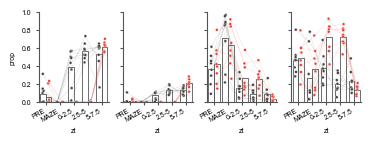

In [4]:
import plotters

fig = subjects.SdFig().fig_supp()

for i, state in enumerate(["NREM", "REM", "AW", "QW"]):
    ax = fig.subplot(fig.gs[i])
    df = states_df[(states_df.state == state)]
    p1 = plotters.Plotter(data=df, x="zt", y="prop", hue="grp")
    p1.stripbarlineplot_sd(palette=subjects.colors_sd())
    ax.set_ylim(0, 1)

    if i > 0:
        ax.set_yticklabels([])
        ax.set_ylabel("")

fig.savefig(subjects.figpath_sd / "state_prop", format="svg")

Run stats on QW and AW from SD1 to SD2

In [8]:
states_df

,zt,name,session,grp,state,prop
0,PRE,RatJDay2,0,NSD,AW,0.431430
1,MAZE,RatJDay2,0,NSD,AW,0.851820
2,0-2.5,RatJDay2,0,NSD,AW,0.177225
3,2.5-5,RatJDay2,0,NSD,AW,0.013778
4,5-7.5,RatJDay2,0,NSD,AW,0.138225
...,...,...,...,...,...,...
395,PRE,RatVDay2,15,SD,REM,0.035445
396,MAZE,RatVDay2,15,SD,REM,0.000000
397,0-2.5,RatVDay2,15,SD,REM,0.000000
398,2.5-5,RatVDay2,15,SD,REM,0.000000


In [10]:
from scipy.stats import ttest_rel
sd_states = states_df[states_df.grp == "SD"]
sd_states[(sd_states.state == "QW") & (sd_states.zt == "0-2.5")]

,zt,name,session,grp,state,prop
202,0-2.5,RatJDay1,8,SD,QW,0.419182
207,0-2.5,RatKDay1,9,SD,QW,0.837408
212,0-2.5,RatNDay1,10,SD,QW,0.613962
217,0-2.5,RatSDay3,11,SD,QW,0.925999
222,0-2.5,RatRDay2,12,SD,QW,0.566901
227,0-2.5,RatUDay1,13,SD,QW,0.839522
232,0-2.5,RatUDay4,14,SD,QW,0.781329
237,0-2.5,RatVDay2,15,SD,QW,0.807107


In [14]:
from scipy.stats import ttest_rel
sd_states = states_df[states_df.grp == "SD"]
for state in ["AW", "QW"]:
    res= ttest_rel(sd_states[(sd_states.state == state) & (sd_states.zt == "0-2.5")].prop,
                       sd_states[(sd_states.state == state) & (sd_states.zt == "2.5-5")].prop)
    print(f"{state}: p={res.pvalue}, stat={res.statistic}, df={res.df}")

AW: p=0.7692616324314748, stat=0.3049635884785373, df=7
QW: p=0.9583597860099203, stat=-0.054109558001711286, df=7


In [ ]:
fig = plotting.Fig(4, 5)
states = ["AW", "QW", "NREM", "REM"]
colors = ["#2f2d2d", "#8c8c8c", "#3368db", "#33dbae"]
zts = states_df.zt.unique()
for i, zt in enumerate(zts):
    df = states_df[states_df.zt == zt]
    names = df.name.values
    state_prop = df.loc[:, ["AW", "QW", "REM", "NREM"]]
    ax = fig.subplot(fig.gs[i])
    ax.set_xlabel(zt)

    left = np.zeros(len(names))
    for s, state in enumerate(states):
        y = state_prop[state].values
        ax.barh(names, y, left=left, color=colors[s])
        left = y + left

### Visualize conctenated active waking epochs

In [ ]:
from neuropy.utils.signal_process import FourierSg, WaveletSg
from neuropy.core import Signal

sess = subjects.nsd.ratUday2[0]
# states = sess.brainstates["QW"] + sess.brainstates["AW"] + sess.brainstates["REM"]
eeg = []
for state_name in ["QW", "AW", "REM"]:
    states = sess.brainstates[state_name]
    eeg.append(sess.eegfile.get_frames_within_epochs(states, 58))

eeg = Signal(traces=np.hstack(eeg), sampling_rate=1250)
spect = FourierSg(eeg, window=2, overlap=0.8, norm_sig=True).freq_slice(0, 30)
# wspect = WaveletSg(eeg, freqs=np.arange(0.25, 30, 0.25), ncycles=10)
# spect_thratio = spect.theta_delta_ratio
# wspect_thratio = wspect.theta_deltaplus_ratio

In [ ]:
_, ax = plt.subplots()

ax.pcolormesh(spect.time, spect.freqs, spect.traces, vmax=0.6, cmap="binary")

### Amount/proportion NREM across zt epochs/blocks

In [ ]:
sessions = subjects.pf_sess()

nrem_df = []
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    nrem = sess.brainstates["NREM"]

    zt_starts = np.arange(post[0], post[0] + 7.35 * 3600, 300)
    zt_stops = zt_starts + 900
    zt_labels = np.arange(len(zt_starts)).astype("str")
    zt_epochs = sess.paradigm.from_array(zt_starts, zt_stops, zt_labels)

    for e in zt_epochs.itertuples():
        e_duration = nrem.time_slice(e.start, e.stop, strict=False).durations.sum()
        e_df = pd.DataFrame({"duration": e_duration}, index=[0])
        e_df["zt"] = e.label
        e_df["session"] = s
        e_df["name"] = sess.animal.name + sess.animal.day
        e_df["grp"] = sess.tag
        nrem_df.append(e_df)

nrem_df = pd.concat(nrem_df, ignore_index=True)
subjects.GroupData().save(nrem_df, "nrem_duration_NREM")

In [ ]:
fig = plotting.Fig(8, 5)

ax = fig.subplot(fig.gs[0])

# for g, grp in enumerate(["NSD", "SD"]):
mean_duration = nrem_df.groupby(["grp", "zt"]).mean(numeric_only=True).reset_index()
mean_duration["zt"] = mean_duration["zt"].astype("float") * (5 / 60)
mean_duration["duration"] = mean_duration["duration"] / (900)

sns.lineplot(data=mean_duration, x="zt", y="duration", hue="grp")
ax.legend("", frameon=False)
ax.set_ylim(0, 1)

### Amount/proportion NREM across zt epochs/blocks aligned by NREM

In [ ]:
sessions = subjects.pf_sess()

nrem_df = []
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    nrem = sess.brainstates["NREM"]
    good_nrem = (
        sess.brainstates.label_slice(["NREM"])
        .time_slice(*post, strict=False)
        .duration_slice(min_dur=120)
    )
    nrem_onset = good_nrem[0].flatten()[0]
    # if sess.tag == "SD":
    # nrem_onset = post[0] + 5 * 3600
    print(sess.tag, sess.sub_name, (nrem_onset - post[0]) / 3600)

    zt_starts = np.arange(nrem_onset, post[0] + 7.35 * 3600, 300)
    zt_stops = zt_starts + 900
    zt_labels = np.arange(len(zt_starts)).astype("str")
    zt_epochs = sess.paradigm.from_array(zt_starts, zt_stops, zt_labels)

    for e in zt_epochs.itertuples():
        e_duration = nrem.time_slice(e.start, e.stop, strict=False).durations.sum()
        e_df = pd.DataFrame({"duration": e_duration}, index=[0])
        e_df["zt"] = e.label
        e_df["session"] = s
        e_df["name"] = sess.animal.name + sess.animal.day
        e_df["grp"] = sess.tag
        nrem_df.append(e_df)

nrem_df = pd.concat(nrem_df, ignore_index=True)
subjects.GroupData().save(nrem_df, "nrem_duration_aligned_by_nrem_onset")

In [ ]:
fig = plotting.Fig(8, 5)

ax = fig.subplot(fig.gs[0])

# for g, grp in enumerate(["NSD", "SD"]):
mean_duration = nrem_df.groupby(["grp", "zt"]).mean(numeric_only=True).reset_index()
mean_duration["zt"] = mean_duration["zt"].astype("float") * (5 / 60)
mean_duration["duration"] = mean_duration["duration"] / (900)

sns.lineplot(data=mean_duration, x="zt", y="duration", hue="grp")
ax.legend("", frameon=False)
ax.set_ylim(0, 1)

### Amount/proportion WAKE across zt epochs/blocks aligned by light cycle

In [ ]:
sessions = subjects.pf_sess()

wake_df = []
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    wake = sess.brainstates.label_slice(["AW", "QW"]).set_labels("WK").merge_neighbors()

    zt_starts = np.arange(post[0], post[0] + 7.35 * 3600, 300)
    zt_stops = zt_starts + 900
    zt_labels = np.arange(len(zt_starts)).astype("str")
    zt_epochs = sess.paradigm.from_array(zt_starts, zt_stops, zt_labels)

    for e in zt_epochs.itertuples():
        e_duration = wake.time_slice(e.start, e.stop, strict=False).durations.sum()
        e_df = pd.DataFrame({"duration": e_duration}, index=[0])
        e_df["zt"] = e.label
        e_df["session"] = s
        e_df["name"] = sess.animal.name + sess.animal.day
        e_df["grp"] = sess.tag
        wake_df.append(e_df)

wake_df = pd.concat(wake_df, ignore_index=True)
subjects.GroupData().save(wake_df, "wake_duration_aligned_by_WAKE")

In [ ]:
mean_duration

In [ ]:
fig = plotting.Fig(8, 5)

ax = fig.subplot(fig.gs[0])

# for g, grp in enumerate(["NSD", "SD"]):
mean_duration = wake_df.groupby(["grp", "zt"]).mean(numeric_only=True).reset_index()
mean_duration["zt"] = mean_duration["zt"].astype("float") * (5 / 60)
mean_duration["duration"] = mean_duration["duration"] / (900)

sns.lineplot(data=mean_duration, x="zt", y="duration", hue="grp", drawstyle="steps-mid")
ax.legend("", frameon=False)
ax.set_ylim(0, 1)

### Comparing bout duration of NREM and REM between NSD and SD

In [ ]:
sessions = subjects.ripple_sess()

states_duration_df = []
for s, sess in enumerate(sessions):
    zt_epochs = sess.get_zt_epochs()[2:]
    states = sess.brainstates.label_slice(["NREM", "REM"])

    for e in zt_epochs.itertuples():
        indx = (states.starts >= e.start) & (states.starts <= e.stop)
        e_states = states[indx]

        df = pd.DataFrame(
            dict(
                duration=e_states.durations,
                brainstate=e_states.labels,
                zt=e.label,
                session=s,
                grp=sess.tag,
            )
        )

        states_duration_df.append(df)

states_duration_df = pd.concat(states_duration_df, ignore_index=True)

In [ ]:
_, axs = plt.subplots(1, 2)

for i, state in enumerate(["NREM", "REM"]):
    df = states_duration_df[states_duration_df.brainstate == state]
    sns.stripplot(
        data=df,
        x="zt",
        y="duration",
        hue="grp",
        hue_order=["NSD", "SD"],
        ax=axs[i],
        dodge=True,
    )

### Comparing total duration of NREM and REM between NSD and SD

In [ ]:
sessions = subjects.ripple_sess()

states_duration_df = []
for s, sess in enumerate(sessions):
    zt_epochs = sess.get_zt_epochs()[2:]
    states = sess.brainstates.label_slice(["NREM", "REM"])

    for e in zt_epochs.itertuples():
        e_states = states.time_slice(e.start, e.stop, strict=False)
        df = pd.DataFrame(
            dict(
                nrem_duration=[e_states["NREM"].durations.sum()],
                rem_duration=[e_states["REM"].durations.sum()],
                zt=e.label,
                session=s,
                grp=sess.tag,
            )
        )

        states_duration_df.append(df)

states_duration_df = pd.concat(states_duration_df, ignore_index=True)

In [ ]:
_, axs = plt.subplots()

sns.stripplot(
    data=states_duration_df,
    x="zt",
    y="rem_duration",
    hue="grp",
    hue_order=["NSD", "SD"],
    ax=axs,
    dodge=True,
)

In [ ]:
func = lambda df: df.groupby([])

### What percentage of SD is sleep ?

In [9]:
sessions = subjects.sd.allsess

nrem_df = []
nrem_dur_all = 0
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    nrem_dur = (
        sess.brainstates["NREM"]
        .time_slice(post[0], post[0] + 5 * 3600, strict=False)
        .durations.sum()
    )

    nrem_dur_all += nrem_dur

    nrem_perc = nrem_dur / (5 * 3600)

    df = pd.DataFrame({"nrem_perc": [nrem_perc], "grp": sess.tag})
    nrem_df.append(df)

nrem_df = pd.concat(nrem_df, ignore_index=True)

In [10]:
nrem_dur_all / (8 * 5 * 3600)

0.0013708140781261086

<Axes: xlabel='grp', ylabel='nrem_perc'>

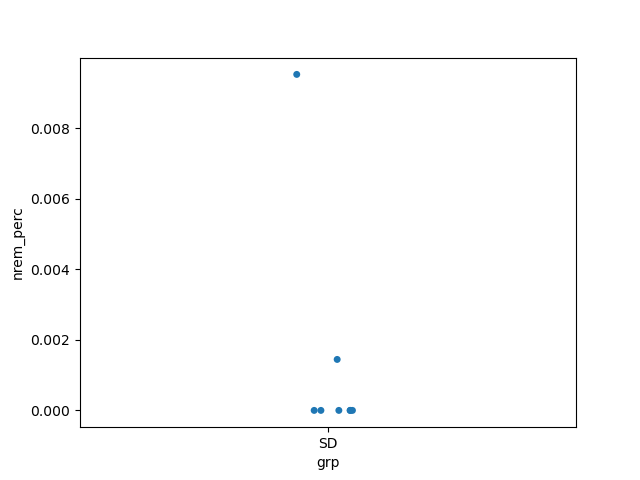

In [7]:
_, ax = plt.subplots()

sns.stripplot(data=nrem_df, x="grp", y="nrem_perc")